In [1]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

%matplotlib inline

In [2]:
%run dow_jones_index.py

In [3]:
# xl := X_learn
# xt := X_test
# yl := y_learn
# yt := y_test
xl, xt, yl, yt = getResampledDowJonesData(scale='std', components=None, splitByDate=None)

In [4]:
xl.head()

,volume,percent_change_price,percent_change_high,percent_change_low,days_to_next_dividend,percent_return_next_dividend
date,,,,,,
2011-01-09,1.772507,0.246789,0.906184,0.459637,0.959141,0.373363
2011-01-16,-0.747572,0.965636,0.540003,0.645977,-0.347364,0.168530
2011-01-23,-0.138551,-0.095949,-0.557618,0.113095,-0.471793,0.235064
2011-01-30,1.157549,-0.782990,1.178983,0.145536,-1.778299,0.709323
2011-02-06,-0.248170,1.673244,1.495057,1.101795,-1.299247,-0.755826


In [5]:
yl.head()

,percent_change_next_weeks_price
date,
2011-01-09,1.322282
2011-01-16,0.156960
2011-01-23,-0.597219
2011-01-30,2.099038
2011-02-06,0.922095


In [6]:
linreg = LinearRegression().fit(xl, yl)

In [7]:
# pyl := predicted yl
# pyt := predicted yt
pyl = linreg.predict(xl)
pyt = linreg.predict(xt)

In [8]:
r2_score(yl, pyl)

0.8398193841448452

In [9]:
mean_squared_error(yl, pyl)

0.19625989812809252

In [10]:
mean_absolute_error(yl, pyl)

0.39265408308784794

In [11]:
r2_score(yt, pyt)

0.10001558749383577

In [12]:
mean_squared_error(yt, pyt)

3.7345042658925

In [13]:
mean_absolute_error(yt, pyt)

1.473699527972607

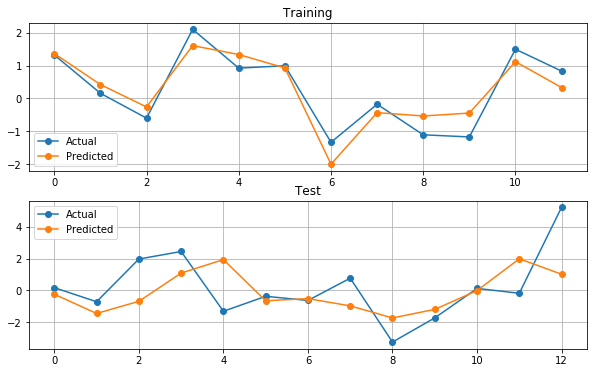

In [14]:
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(yl.values.flatten(), 'o-', label='Actual')
plt.plot(pyl, 'o-', label='Predicted')
plt.grid(True)
plt.legend(loc='best')
plt.title('Training')
plt.subplot(2, 1, 2)
plt.plot(yt.values.flatten(), 'o-', label='Actual')
plt.plot(pyt, 'o-', label='Predicted')
plt.grid(True)
plt.legend(loc='best')
plt.title('Test')
plt.show()